# Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis)([another link](https://www.geeksforgeeks.org/clustering-in-machine-learning/)) is basically a type of unsupervised learning method. An unsupervised learning method is a method in which we draw references from datasets consisting of input data without labelled responses. Generally, it is used as a process to find meaningful structure, explanatory underlying processes, generative features, and groupings inherent in a set of examples. We will use again
[scikit](https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html#sphx-glr-auto-examples-cluster-plot-digits-linkage-py)

In [1]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# other packages
import pandas as pd
import csv
import re

RDKit WARNING: [19:37:13] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
# load mtor, we want to remember source of data and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("DRD1.csv") as inp:
    drd1 = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in drd1:
        if m['Smiles'].strip() != '':
            m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
            m["source"] = "drd1"
            m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["rdmol"])

In [3]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

In [4]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *drd1), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df[~df["rdmol"].isna()]

In [5]:
df["rdmol"].isna().sum()

0

In [6]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )
df = df[~df["MQN_1"].isna()]

In [7]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [8]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [9]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

In [10]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

C:\Users\elieb\miniconda3\envs\cdd\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


## Hierarchical clustering
[Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)

In [13]:
df.isna().sum()

index       0
Smiles      0
source      0
rdmol       0
fps         0
           ..
nPCA_42    31
mds_x      31
mds_y      31
tsne_x     31
tsne_y     31
Length: 100, dtype: int64

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

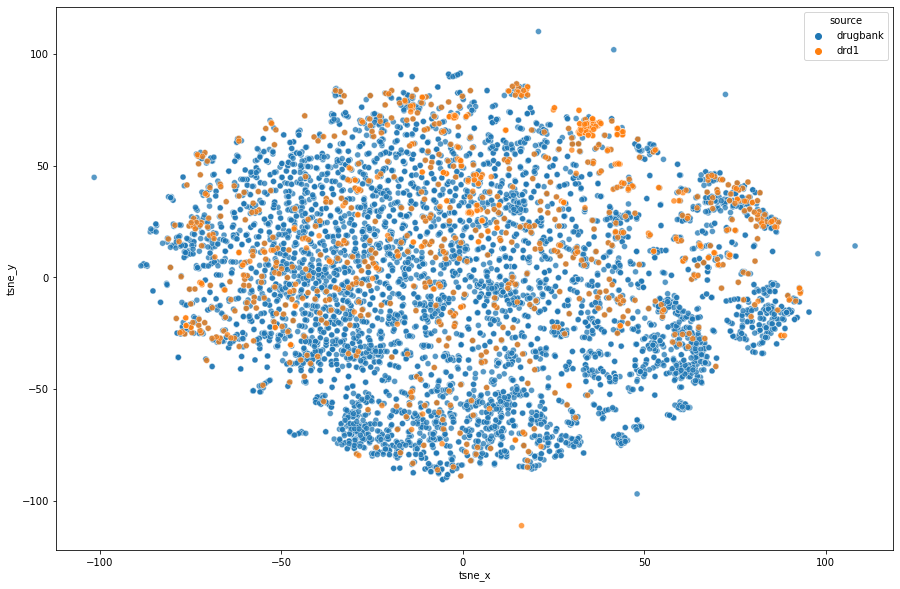

In [11]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    clustering.fit(df[["tsne_x", "tsne_y"]])

    fig, ax = pyplot.subplots(figsize=(15,10))
    p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue=[pyplot.cm.nipy_spectral(l / 10.) for l in clustering.labels_],
                      ax=ax,
                      alpha=0.75,
                      legend=False
                     ).set_title(f"Linkage {linkage}")


In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    clustering.fit(df[[f"nPCA_{x}" for x in range(1, 43)]])

    fig, ax = pyplot.subplots(figsize=(15,10))
    p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue=[pyplot.cm.nipy_spectral(l / 10.) for l in clustering.labels_],
                      ax=ax,
                      alpha=0.75,
                      legend=False,
                     ).set_title(f"Linkage {linkage}")


## K-means clustering algorithm 
It is the simplest unsupervised learning algorithm that solves clustering problem. K-means algorithm partition n observations into k clusters where each observation belongs to the cluster with the nearest mean serving as a prototype of the cluster.

In [ ]:
reduced_data = df[["tsne_x", "tsne_y"]]
n_clusters = 10
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)
centroids = kmeans.cluster_centers_
# Put the result into a color plot
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x= [*df["tsne_x"], *centroids[:, 0]],
                  y=[*df["tsne_y"], *centroids[:, 1]],
                  hue=[pyplot.cm.nipy_spectral(l / (n_clusters+1)) for l in (*kmeans.labels_, *(n_clusters for x in range(len(centroids))))],
                  size=[*[1 for l in kmeans.labels_],*[50 for x in range(len(centroids))]],
                  ax=ax,
                  alpha=0.75,
                  legend=False 
                 )



In [ ]:
reduced_data = df[[f"nPCA_{x}" for x in range(1, 43)]]
n_clusters = 10
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)
centroids = kmeans.cluster_centers_

# Put the result into a color plot
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x= [*df["nPCA_1"], *centroids[:, 0]],
                  y=[*df["nPCA_2"], *centroids[:, 1]],
                  hue=[pyplot.cm.nipy_spectral(l / (n_clusters+3)) for l in (*kmeans.labels_, *(n_clusters for x in range(len(centroids))))],
                  size=[*[1 for l in kmeans.labels_],*[50 for x in range(len(centroids))]],
                  ax=ax,
                  alpha=0.75,
                  legend=False 
                 )

## How can we use clusters?
### Use case 1: Grouping
Clustering is often used to group similar instances or to find outliers.
### Use case 2: Classification
Clustering is unsupervised, however each cluster can get its own label/class. If clustering was performed on classed instances, each cluster can be labeled with the prevailing class inside this cluster.

## What to do
* Familiarize yourself with clustering methods. If mentioned methods in this exercise are not enough you can surely find more methods in scikit-learn. You can see that the methods work but you sometimes you don't get "desired" result.
* Try to find the "best" setting (algorithm, descriptors, metrics, linkage) where clusters have the highest [purity](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation) (well, don't use the same number of clusters as compounds, try reasonable counts max 50 clusters)
* Try to classify your data e.g. to ligands and non-ligands (work with 20% of your data as you don't know their class, hint. this unknown data should be from both classes). How succesful is your classification? [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) could help.

You can use precomputed distances, however be careful if it works.

In [ ]:
n_clusters = 10
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

for linkage in ('average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, affinity="precomputed", n_clusters=n_clusters)
    clustering.fit(dist_mat)

    fig, ax = pyplot.subplots(figsize=(15,10))
    p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue=[pyplot.cm.nipy_spectral(l / n_clusters) for l in clustering.labels_],
                      ax=ax,
                      alpha=0.75,
                      legend=False,
                     ).set_title(f"Linkage {linkage}")

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

for linkage in ('average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, affinity="precomputed", n_clusters=n_clusters)
    clustering.fit(dist_mat)

    fig, ax = pyplot.subplots(figsize=(15,10))
    p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue=[pyplot.cm.nipy_spectral(l / n_clusters) for l in clustering.labels_],
                      ax=ax,
                      alpha=0.75,
                      legend=False,
                     ).set_title(f"Linkage {linkage}")